In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions


import pandas as pd
import numpy as np

from linux_qm.src.render import indigo, draw_reacting_mapnums
from linux_qm.src.util import load_smiles3D
from linux_qm.qm.orca.orca import OrcaDriver

In [52]:
df = pd.read_csv('../data/slv_amides/amide_training_set.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rxn_id            15999 non-null  int64  
 1   acid_smi          15999 non-null  object 
 2   amine_smi         15999 non-null  object 
 3   product_smi       15999 non-null  object 
 4   activators_names  9719 non-null   object 
 5   yield             15999 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 750.1+ KB


In [53]:
df['rxn_smi'] = df.amine_smi + '.' + df.acid_smi + '>>' + df.product_smi
df.rxn_smi

0        N[C@@H](CCCCNC(=O)C(F)(F)F)C(=O)O.OC(CCCCCCCCC...
1        NCC(=O)NCC(=O)NCC(=O)O.OC(CSC(C)=O)=O>>[CH3:1]...
2        NCCN.OC(=O)CCN(CCNC(=O)CCN(CCOCCOCCOCC1OCCO1)C...
3        NCCN.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH:3]([O:19]...
4        NCc1cccc(CN)c1.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH...
                               ...                        
15994    CCO[Si](CCCN)(OCC)OCC.OC(=O)CC=O>>[CH3:1][CH2:...
15995    NCCC(=O)O.OC(C(=C)C)=O>>[CH2:1]=[C:2]([C:4]([N...
15996    N1CCOCC1.OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]...
15997    CC[C@H](C)N.OC(=O)c1cc(Cl)cc(F)[n]1>>[CH3:1][C...
15998    NCc1ccccc1.OC(=O)c1[n]cc[n][n]1>>[O:1]=[C:2]([...
Name: rxn_smi, Length: 15999, dtype: object

[NH2:1][c:2]1[cH:8]cc(O)[cH:4][cH:3]1.[CH3:9][C:10](=O)[OH:11]>>CC(=O)[NH:1][c:2]1[cH:3][cH:4][c:10]([OH:11])[cH:9][cH:8]1
Reacting Atom Idx: ((0, 2, 3, 4, 5, 6), (0, 1, 2))
Mapped reacting atom: N 1
Mapped reacting atom: C 8
Mapped reacting atom: C 0
Mapped reacting atom: C 0
Mapped reacting atom: O 0
Mapped reacting atom: C 4
Mapped reacting atom: C 9
Mapped reacting atom: C 10
Mapped reacting atom: O 0


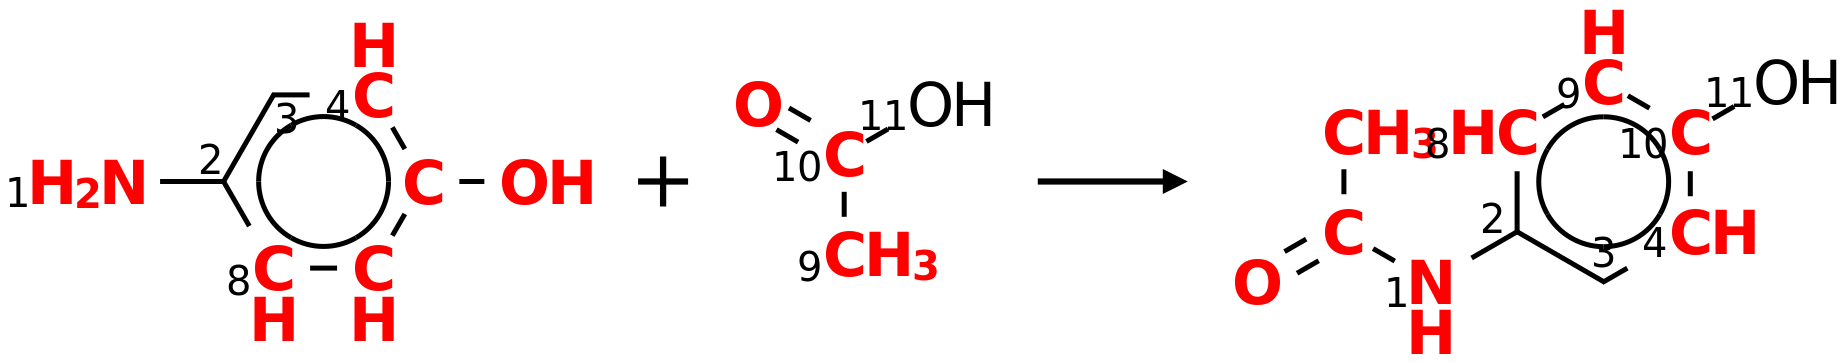

[1, 8, 0, 0, 0, 4, 9, 10, 0]

In [54]:
# rxn_smi = df.rxn_smi.sample(1).iat[0]
rxn_smi = "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc2ccc(O)cc2)=O"

ind_rxn = indigo.loadReaction(rxn_smi)
ind_rxn.automap("discard")
rxn_smi = ind_rxn.smiles()

print(rxn_smi)

draw_reacting_mapnums(rxn_smi)

In [55]:
import re

re.sub(r':\d+','',  rxn_smi)

'[NH2][c]1[cH]cc(O)[cH][cH]1.[CH3][C](=O)[OH]>>CC(=O)[NH][c]1[cH][cH][c]([OH])[cH][cH]1'

In [56]:
from rxnmapper import BatchedMapper
rxn_mapper = BatchedMapper(batch_size=16)

def rxn_map(rxn_smi):
    clear_smi = re.sub(r':\d+','',  rxn_smi)
    mapped_rxn = list(rxn_mapper.map_reactions([clear_smi]))[0]
    return mapped_rxn

Reacting Atom Idx: ((0,), (1, 3))
Mapped reacting atom: N 4
Mapped reacting atom: C 2
Mapped reacting atom: O 0


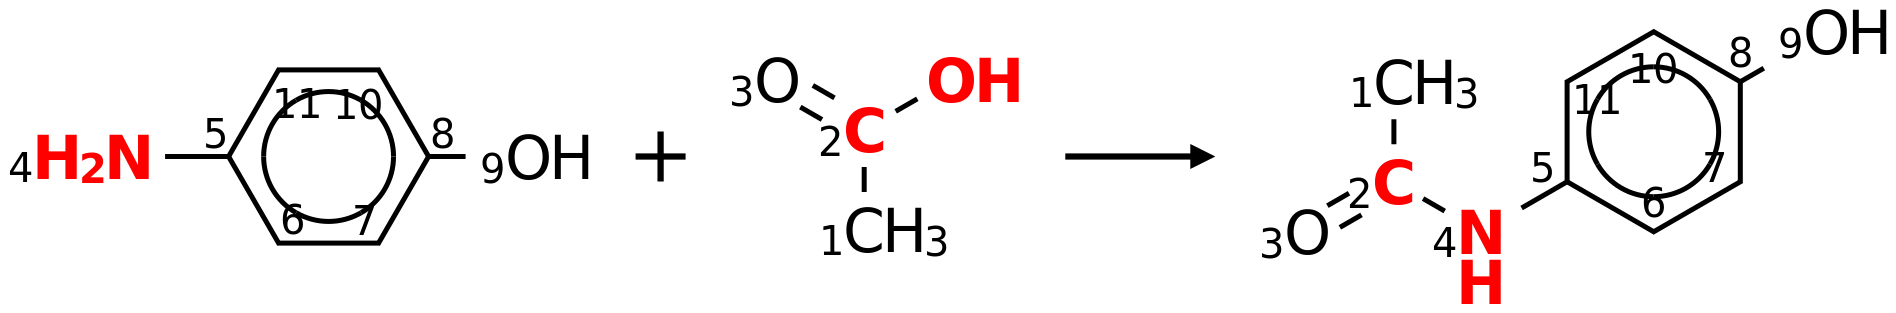

[4, 2, 0]

In [58]:
draw_reacting_mapnums(rxn_map(rxn_smi))

In [104]:
def automap_rxn(rxn_smi):
    ind_rxn = indigo.loadReaction(rxn_smi)
    ind_rxn.automap("discard")
    return ind_rxn.smiles()


def get_amine_atoms(mol, reacting_nitrogen_idx: int):
    amine_aids = [reacting_nitrogen_idx]
    atom = mol.GetAtomWithIdx(reacting_nitrogen_idx)
    for a in atom.GetNeighbors():
        if a.GetSymbol() == 'C':
            amine_aids.append(a.GetIdx())
    return amine_aids


def orca_calculation(conf):
    orca = OrcaDriver()

    orca.options['method'] = 'XTB2'
    orca.geometry_optimization(conf)

    # orca.options['method'] = 'HF-3c'
    orca.options['n_jobs'] = 8
    orca.options['method'] = 'BP86 def2-SVP def2/J D3BJ RIJCOSX'
    data = orca.single_point(conf)

    # data = orca.geometry_optimization(conf)
    return data

def gen_amine_electronic(rxn_smi):
    # rxn_smi = automap_rxn(rxn_smi)
    rxn_smi = rxn_map(rxn_smi)

    # load rxn
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get amine mol
    amine, _ = rxn.GetReactants()
    mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)

    # qm calculation
    data = orca_calculation(mol.GetConformer())

    # parse output
    amine_raids = get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])
    charges = np.hstack([data.atomcharges['mulliken'][amine_raids], data.atomcharges['lowdin'][amine_raids]])
    print(charges)
    return charges

In [105]:
import logging
logging.getLogger().setLevel(logging.WARNING)

reactions = [
    # "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(Si)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    "Nc1ccc(NC)cc1.CC(O)=O>>CC(Nc1ccc(NC)cc1)=O",
    "Nc1ccc(N(C)C)cc1.CC(O)=O>>CC(Nc1ccc(N(C)C)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O",
    # "Nc1ccc(Br)cc1.CC(O)=O>>CC(Nc1ccc(Br)cc1)=O",
    # "Nc1ccc(I)cc1.CC(O)=O>>CC(Nc1ccc(I)cc1)=O",
]

# labels = ['C', 'N', 'O', 'F']
labels = ['NH2', 'NHMe', 'NMe2']
# labels = ['C', 'NH2' ,'OH', 'F', 'Cl', 'Br', 'I']
amine_descr = np.empty((0, 4))
for rxn_smi in reactions:
    d = gen_amine_electronic(rxn_smi)
    amine_descr = np.vstack([amine_descr, d])
res = pd.DataFrame(amine_descr, columns=['mul_N', 'mul_C', 'lod_N', 'lod_C'], index=labels)
res

[-0.498682  0.083398 -0.315909  0.066168]
[-0.49885   0.082267 -0.316177  0.064973]
[-0.498554  0.080963 -0.316097  0.064135]


,mul_N,mul_C,lod_N,lod_C
NH2,-0.498682,0.083398,-0.315909,0.066168
NHMe,-0.498850,0.082267,-0.316177,0.064973
NMe2,-0.498554,0.080963,-0.316097,0.064135


In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

res.iloc[:] = scaler.fit_transform(res)
res

,mul_N,mul_C,lod_N,lod_C
NH2,0.110003,1.194735,1.353122,1.289822
NHMe,-1.276036,0.057961,-1.032645,-0.142648
NMe2,1.166033,-1.252696,-0.320476,-1.147175


<Axes: >

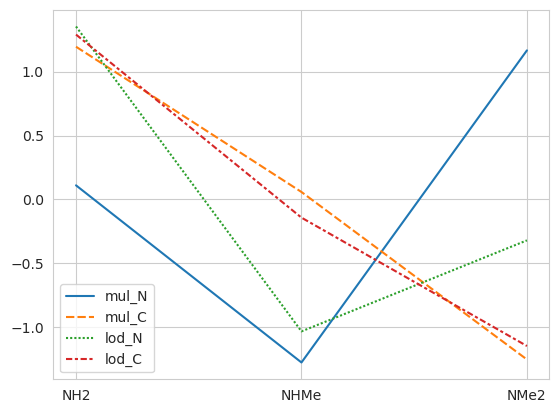

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    res
)

In [332]:
rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
rxn.Initialize()

amine, acid = rxn.GetReactants()
rxn.GetReactingAtoms()

[15:10:44] reactant 0 has no mapped atoms.
[15:10:44] reactant 1 has no mapped atoms.
[15:10:44] product 0 has no mapped atoms.


((0, 1, 2, 3, 4, 5, 6, 7), (0, 1, 2, 3))

In [144]:
mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [331]:
%%time

# Calculate ORCA descriptors
from linux_qm.qm.orca.orca import OrcaDriver

orca = OrcaDriver(options={'method': 'HF-3c'})

data = orca.single_point(mol.GetConformer())

CPU times: user 8.4 ms, sys: 1.59 ms, total: 10 ms
Wall time: 280 ms


In [146]:
def get_amine_atoms(mol, reacting_nitrogen_idx: int):
    amine_aids = [reacting_nitrogen_idx]
    atom = mol.GetAtomWithIdx(reacting_nitrogen_idx)
    for a in atom.GetNeighbors():
        if a.GetSymbol() == 'C':
            amine_aids.append(a.GetIdx())
    return amine_aids
    # atom

amine_raids = get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])
np.array(data.metadata['coords'])[amine_raids]

array([['N', '2.29510384', '-0.14618223', '0.31808013'],
       ['C', '0.91745352', '-0.08647533', '0.07466563']], dtype='<U32')

In [153]:
charges = data.atomcharges['mulliken'][amine_raids]
charges.shape

(2,)

In [154]:
charges = np.hstack([charges, data.atomcharges['lowdin'][amine_raids]])

array([-0.489984,  0.095465, -0.309774,  0.086384])

In [141]:
homo = data.moenergies[0][data.homos[0]]
lumo = data.moenergies[0][data.homos[0] + 1]
homo, lumo

(-7.902267852675151, 4.8952737477249)

In [132]:
dir(data)

['OPT_DONE',
 'OPT_NEW',
 'OPT_UNCONVERGED',
 'OPT_UNKNOWN',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attributes',
 '_attrlist',
 '_dictsofarrays',
 '_intarrays',
 '_listsofarrays',
 'arrayify',
 'atomcharges',
 'atomcoords',
 'atommasses',
 'atomnos',
 'charge',
 'check_values',
 'closed_shell',
 'converged_geometries',
 'coreelectrons',
 'dispersionenergies',
 'getattributes',
 'homos',
 'listify',
 'metadata',
 'moenergies',
 'moments',
 'mosyms',
 'mult',
 'natom',
 'nbasis',
 'nelectrons',
 'new_geometries',
 'nmo',
 'scfenergies',
 'scftargets',
 'scfvalues',
 'setattributes',
 'typecheck',
 'unconverged_geometries',
 'unknown_geometries',
 'write',
 'wr

In [13]:
for ridx, reacting in enumerate(rxn.GetReactingAtoms()):
    reactant = rxn.GetReactantTemplate(ridx)
    print(Chem.MolToSmiles(reactant))
    for raidx in reacting:
        atom = reactant.GetAtomWithIdx(raidx)
        mapnum = atom.GetAtomMapNum()
        print('Mapped reacting atom:', atom.GetSymbol(), mapnum)
        # print(Chem.MolToSmiles(reactant))

[NH2:1][CH2:2][CH2:3][OH:4]
Mapped reacting atom: N 1
O[C:6]([c:7]1[c:8]2[s:9][cH:10][c:11]([CH2:12][O:13][c:14]3[c:15]([CH3:16])[cH:17][cH:18][c:19]([NH:20][C:21](=[O:22])[c:23]4[cH:24][cH:25][cH:26][c:27]([Cl:28])[cH:29]4)[cH:30]3)[c:31]2[cH:32][n:33][cH:34]1)=[O:35]
Mapped reacting atom: O 0
Mapped reacting atom: C 6
